# Robustness of Crayfish Nervous System to Environmental pH
## Step 1: Format Data

In [ ]:
import neo, os
import numpy as np
from mne import create_info
from mne.io import RawArray

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
include = '171212'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Locate files.
files = [f for f in os.listdir('raw') if f.endswith('abf')]
files = [f for f in files if include in f]

for f in files:

    ## Load recordings.
    recordings, = neo.AxonIO(filename='raw/%s' %f).read_block().segments
    signal, = recordings.analogsignals

    ## Concatenate raw recordings.
    data = np.hstack([np.asarray(signal, dtype=np.float64)  * 1e-6]).T
    
    ## Create info object.
    sfreq = float(signal.sampling_rate)
    ch_names = ['nerve']
    ch_types = 'eeg'

    info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    ## Create Raw object.
    raw = RawArray(data, info, verbose=False)
        
    ## Save Raw object.  
    raw.save('raw/%s' %f.replace('.abf','_raw.fif'), overwrite=True, verbose=False)
    
print('Done.')

## Step 2: Spike Detection

In [ ]:
import os
import numpy as np
from mne import Epochs
from mne.io import Raw
from spike_sorting import find_threshold, peak_finder

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Filter parameters.
l_freq = 300
h_freq = 3000

## Spike detection parameters.
k = 5

## Epoching parameters.
tmin = -0.002
tmax = 0.001
reject_tmax = -0.001

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

files = [f for f in os.listdir('raw') if f.endswith('fif')]
for f in files:
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load raw.
    raw = Raw('raw/%s' %f, preload=True, verbose=False)

    ## Filter data.
    raw = raw.filter(l_freq, h_freq, picks=[0], method='fir', phase='zero', 
                     fir_design='firwin', verbose=False)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Spike detection.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Extract data.
    data = raw.get_data().squeeze()

    ## Set threshold.
    threshold = find_threshold(data, k)

    ## Detect spikes.
    peak_loc, peak_mag =  peak_finder(data, threshold)
    if not np.any(peak_loc): continue
    
    ## Epoching.
    events = np.vstack([peak_loc, np.zeros_like(peak_loc), np.ones_like(peak_loc)]).T
    epochs = Epochs(raw, events, tmin=tmin, tmax=tmax, picks=[0], baseline=(tmin, reject_tmax),
                    reject=dict(eeg=threshold), reject_tmax=reject_tmax, preload=True, verbose=False)
    
    ## Drop bad epochs. Crop.
    epochs.drop_bad()
    epochs = epochs.crop(reject_tmax, tmax)

    ## Extract data.
    spikes = epochs.get_data().squeeze()
    spikes *= 1e6 # convert to uV
    if np.ndim(spikes) == 1: spikes = spikes.reshape(1,-1)
    
    ## Save.
    np.savez_compressed('spikes/%s' %f.replace('raw.fif','spikes.npz'), spikes=spikes, times=epochs.times,
                        peak_loc=peak_loc, peak_mag=peak_mag)
        
print('Done.')

## Step 3:  Spike Rejection

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import cauchy, norm
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
pH_levels = np.arange(25,80,10)

## PCA parameters.
n_components = 2

## Rejection parameters.
alpha = 0.05

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2, pH_levels.size, figsize=(18,6))
colors = sns.cubehelix_palette(n_colors=6, start=2.5, rot=0, dark=0.05, light=.7)

## Initialize Scikit-Learn objects.
pca = PCA(n_components=n_components, random_state=0)
log_likelihood = lambda arr: np.log( norm(arr.mean(), arr.std()).pdf(arr) )

for i, pH in enumerate(pH_levels):

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Locate files.
    files = sorted([f for f in os.listdir('spikes') if str(pH) in f])
    
    ## Iteratively load files.
    spikes, recordings = [], []
    for f in files:
        npz = np.load('spikes/%s' %f)
        spikes.append(npz['spikes'])
        recordings.append( np.ones(spikes[-1].shape[0]) * int(f.split('_')[-2]) )
    
    ## Concatenate files.
    spikes = np.concatenate(spikes,axis=0)
    recordings = np.concatenate(recordings)
    times = npz['times'] * 1e3
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Spike rejection.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Normalize spikes by maximum value per spike.
    normed = (spikes.T / spikes.max(axis=-1)).T
    
    ## Dimensionality reduction with PCA.
    pca_fit = pca.fit_transform(normed)
    evr = pca.explained_variance_ratio_
    
    ## Compute log-likelihood of spikes relative to template (average).
    log_lik = np.apply_along_axis(log_likelihood, 0, normed)
    log_lik = np.mean(log_lik, axis=-1)
    
    ## Fit to cauchy distribution.
    mu, sd = cauchy.fit(log_lik)
    threshold = cauchy(mu, sd).ppf(alpha)
    ix = log_lik > threshold
    
    ## Save cleaned data.
    np.savez_compressed('templates/spikes_%s.npz' %pH, spikes=spikes[ix], 
                        recordings=recordings[ix], times=times)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plotting..
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Plot PCA.
    axes[0,i].scatter(*pca_fit[ix].T, s=25, color='none', edgecolor='#1f77b4', alpha=0.1)
    axes[0,i].scatter(*pca_fit[~ix].T, s=25, color='none', edgecolor='#d62728', alpha=0.1)
    axes[0,i].set(xlim=(-3,3), xticks=[], xlabel='PCA 1 (%0.1f%%)' %(evr[0]*100), 
           ylim=(-3,3), yticks=[], ylabel='PCA 2 (%0.1f%%)' %(evr[1]*100),
           title='pH = %0.1f' %(pH/10))
    
    ## Plot template.
    mu = normed[ix].mean(axis=0)
    se = normed[ix].std(axis=0) / np.sqrt(normed[ix].shape[0])
    axes[1,i].plot(times, mu, lw=3, color=colors[i])
    axes[1,i].fill_between(times, mu - se, mu + se, color=colors[i], alpha=0.4)
    axes[1,i].set(ylim=(-1.3,1), xlabel='N = %s' %normed[ix].shape[0])
    
sns.despine()
plt.tight_layout()

## Step 4: Spike Shape Analysis

In [ ]:
import os
import numpy as np
from pandas import DataFrame, Series, concat
from scipy.stats import norm, ttest_ind
from mne.stats.cluster_level import _find_clusters as find_clusters

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
pH_levels = np.arange(35,80,10)

## Permutation parameters.
alpha = 0.05
n_shuffles = 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define convenience functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

ttest2way = lambda X: ttest_ind(*X)[0]
return_cols = lambda df, levels, col1, col2: [df.loc[df[col1]==level,col2] for level in levels]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

data = []
for pH in pH_levels:
        
    ## Load and extract data.
    npz = np.load('templates/spikes_%s.npz' %pH)
    spikes, times = npz['spikes'], npz['times']
    
    ## Normalize spikes by maximum value per spike.
    spikes = (spikes.T / spikes.max(axis=-1)).T
    
    ## Assemble DataFrame.
    spikes = DataFrame(spikes, columns=times)
    spikes.insert(0, 'Recording', npz['recordings'])
    spikes.insert(0, 'pH', pH/10)
    
    ## GroupBy pH/Recording. Append.
    data.append(spikes.groupby(['pH','Recording']).mean().reset_index())
    
## Concatenate DataFrames.
data = concat(data).reset_index(drop=True)
pH_levels = np.unique(data.pH)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute observed statistics. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
statistics = DataFrame([], columns=('pH1','pH2','tmin','tmax','t','p'))
pairs = list(zip(pH_levels[:-1], pH_levels[1:]))

## Compute t-threshold for significance.
t_threshold = norm(0,1).isf(alpha/2)

## Compute observed statistics.
for pair in pairs:
    
    ## Compute t-statistics for each time point.
    t_stats = [ttest2way(return_cols(data, pair, 'pH', t)) for t in times]
    
    ## Compute clusters.
    clusters, t_stats = find_clusters(t_stats, t_threshold, tail=0)

    ## Store.
    for c, t in zip(clusters, t_stats):
        series = Series([ pair[0], pair[1], times[c].min(), times[c].max(), t, 1 ], 
                        index=statistics.columns)
        statistics = statistics.append(series, ignore_index=True)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute Permuted statistics. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)
        
## Copy data.
null = data.copy()

## Main loop.
for _ in np.arange(n_shuffles):
    
    ## Shuffle pH label.
    null.pH = np.random.choice(null.pH, null.pH.size, replace=False)
    
    ## Compute permuted statistics.
    t_max = 0
    for pair in pairs:
    
        ## Compute t-statistics for each time point.
        t_stats = [ttest2way(return_cols(null, pair, 'pH', t)) for t in times]

        ## Compute clusters.
        _, t_stats = find_clusters(t_stats, t_threshold, tail=0)
        
        ## Error-catching.
        if not np.any(t_stats): continue
        
        ## Store max statistic.
        if np.max(np.abs(t_stats)) > t_max: t_max = np.max(np.abs(t_stats))
            
    ## Perform family-wise error correction.
    statistics.p += t_max > statistics.t.abs()
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Finalize and save.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Correct p-values.
statistics.p /= n_shuffles + 1

## Save.
statistics.to_csv('nonparametric.csv', index=False)
print('Done.')

## Step 5: Frequency Analysis

## Step XX: Plotting

### Spike Template Plotting

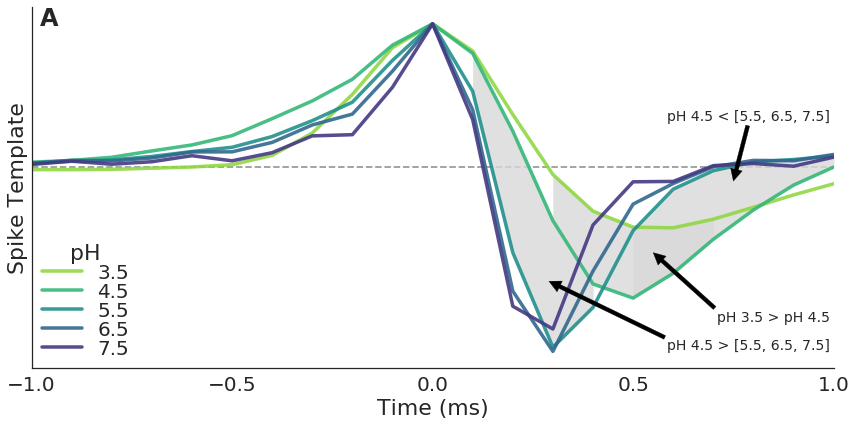

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
pH_levels = np.arange(35,80,10)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

data = []
for pH in pH_levels:
        
    ## Load and extract data.
    npz = np.load('templates/spikes_%s.npz' %pH)
    spikes, times = npz['spikes'], npz['times']
    
    ## Normalize spikes by maximum value per spike.
    spikes = (spikes.T / spikes.max(axis=-1)).T
    
    ## Assemble DataFrame.
    spikes = DataFrame(spikes, columns=times)
    spikes.insert(0, 'Recording', npz['recordings'])
    spikes.insert(0, 'pH', pH/10)
    
    ## GroupBy pH/Recording. Append.
    data.append(spikes.groupby(['pH','Recording']).mean().reset_index())

## Concatenate DataFrames.
data = concat(data).reset_index(drop=True)
pH_levels = np.unique(data.pH)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot action potentials.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,6))
colors = sns.color_palette('viridis_r', n_colors=pH_levels.size)

## Plot action potentials.
gb = data.groupby('pH').mean().filter(items=times)
for pH, color in zip(pH_levels, colors):
    ax.plot(times, gb.loc[pH], lw=3.5, color=color, alpha=0.9)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Fill-in 
ix = np.logical_and(times >= 0.3, times <= 0.7)
ax.fill_between(times[ix], gb.loc[4.5][ix], gb.loc[3.5][ix], color='#d9d9d9', alpha=0.8)
ax.annotate('pH 3.5 > pH 4.5', xy=(0.55, -0.6), xytext=(0.99, -1), 
            xycoords='data', fontsize=14, ha='right', va='top',
            arrowprops=dict(facecolor='black', shrink=1e-6), )

ix = np.logical_and(times >= 0.1, times <= 0.4)
ax.fill_between(times[ix], gb.loc[4.5][ix], gb.loc[5.5][ix], color='#d9d9d9', alpha=0.8)
ax.annotate('pH 4.5 > [5.5, 6.5, 7.5]', xy=(0.29, -0.8), xytext=(0.99, -1.2), 
            xycoords='data', fontsize=14, ha='right', va='top',
            arrowprops=dict(facecolor='black', shrink=1e-6))
    
ix = np.logical_and(times >= 0.5, times <= 1.0)
ax.fill_between(times[ix], gb.loc[5.5][ix], gb.loc[4.5][ix], color='#d9d9d9', alpha=0.8)
ax.annotate('pH 4.5 < [5.5, 6.5, 7.5]', xy=(0.75, -0.1), xytext=(0.99, 0.4), 
            xycoords='data', fontsize=14, ha='right', va='top',
            arrowprops=dict(facecolor='black', shrink=1e-6))

## Add info.
ax.hlines(0, times.min(), times.max(), linestyle='--', alpha=0.4, zorder=-1)
ax.set(xlim=(times.min(), times.max()), xticks=np.arange(times.min(),times.max()+1e-3,0.5),
       xlabel='Time (ms)', yticks=[], ylabel='Spike Template')
ax.legend(loc=3, borderpad=0, labelspacing=0)
ax.legend_.set_title('pH', prop=dict(size=22))
ax.annotate('A', xy=(0,0), xytext=(0.01,0.95), xycoords='axes fraction', fontsize=24, weight='bold')

sns.despine()
plt.tight_layout()